# Explore
# Matched DMV Crash and Hospital data (MV104/SPARCS)

data provided by dohmh

Exploring matched data

### Variables given - from crash data
date/time of crash
* date - date of crash

person injured
* f_per_age
* f_per_sex - male, female
* f_per_role (f_per_role_doh) - driver, passenger, pedestrian, bicyclist, motorcyclist (dohmh was able to extract motorcylists), unknown
* f_per_ejected - ejected, not ejected, unknown
* f_per_loc - at intersection, not at intersection, unknown (majority are unknown)

injury information
* f_inj_status_num - 1-6, unknown
* f_inj_status - conscious stated, not conscious states, death
* f_inj_type - 14 types, unknown
* f_inj_loc - 12 locations, unknown

road information
* f_road_light - 5 types, unknown
* f_road_surf_bi - dry, not dry unknown
* f_road_surf - dry, flooded, muddy, slush, snow/ice, wet, unknown (almost all dry)
* f_road_weather - clear, cloudy, rain, snow, sleet, fog, other, unknown
* f_road_control - none, traffic signal, stop sign, other, unknown

vehicle information
* f_act_veh - what the vehicle the person was in was doing - need to narrow donw
* f_veh - car, suburban, pickup, van, truck, pedestrian, bicyclist, unknown
* f_veh_doh - car/van/pickup, truck, taxi, bus, other(bike, motorcycle, ped)
* f_oveh_doh - same as above. but with two more unknown vars 6 and 7


In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()
# reorganize into pedestrian/bicyclist and two-vehicle crashes
base, ped, twoVeh = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()
# included biss data from linked onto ped and twoveh (dropping anything not in linked)
base = db.mergeBiss(base,linked)
ped = db.mergeBiss(ped,linked)
twoVeh = db.mergeBiss(twoVeh,linked)

#format and categorize variables
ped = db.formatVars(ped)
twoVeh = db.formatVars(twoVeh)

print 'linked base', base.shape
print 'linked ped',ped.shape
print 'linked two-veh',twoVeh.shape


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


crash table (522108, 26)
person table (1502797, 22)
vehicle table (1092922, 20)
base (1114090, 42)
two veh (651501, 75)
ped (95292, 78)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked base (69657, 45)
linked ped (17624, 103)
linked two-veh (36907, 98)


In [3]:
print ped.shape,twoVeh.shape

(17624, 103) (36907, 98)


In [4]:
crash.date.min(),crash.date.max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [5]:
base.date.min(),crash.date.max()

(Timestamp('2010-10-25 00:00:00'), Timestamp('2013-12-31 00:00:00'))

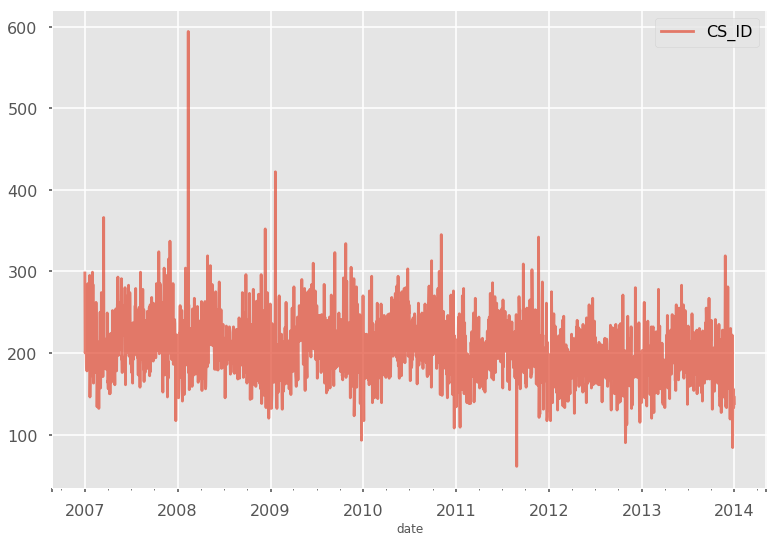

In [6]:
# number of crashes (all)
crash.groupby('date').count()[['CS_ID']].plot(alpha=.7)

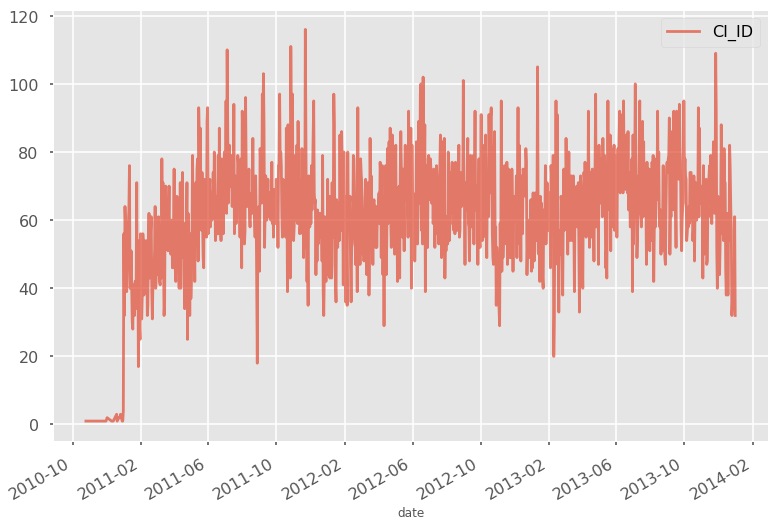

In [7]:
# number of injured (matched)
base.groupby('date').count()[['CI_ID']].plot(alpha=.7)

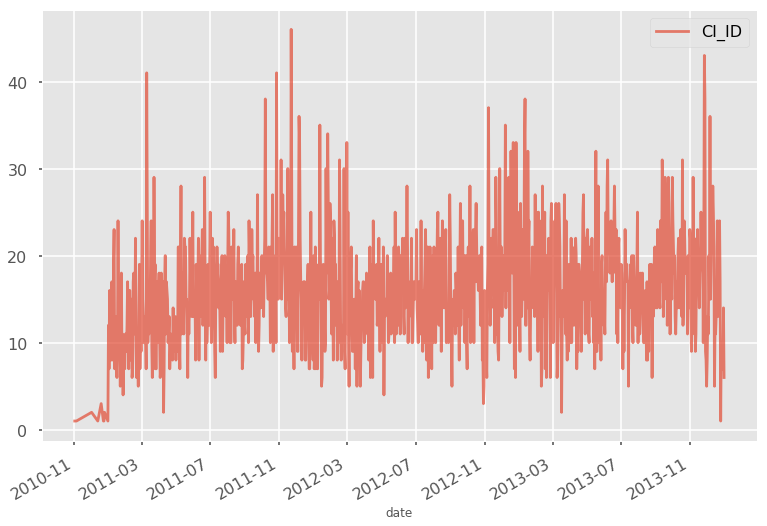

In [8]:
ped.groupby('date').count()[['CI_ID']].plot(alpha=.7)

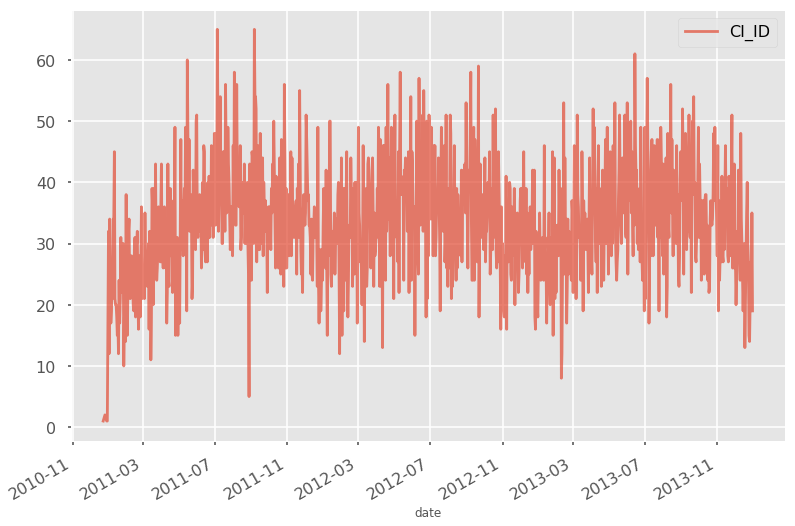

In [9]:
twoVeh.groupby('date').count()[['CI_ID']].plot(alpha=.7)

In [10]:
print 'crashes per year',crash.shape[0]/7

crashes per year 74586


In [11]:
aInjury = ind[ind.SEVERITY.isin(['A'])].CS_ID

print 'crashes with A injuries per year',crash[(crash.CS_ID.isin(aInjury))].shape[0]/7

crashes with A injuries per year 3505


In [12]:
abcInjury = ind[ind.SEVERITY.isin(['A','B','C'])].CS_ID

print 'crashes with A,B,orC injuries per year',crash[(crash.CS_ID.isin(abcInjury))].shape[0]/7

crashes with A,B,orC injuries per year 47959


In [13]:
ped.groupby('EVNTT_ID').count()[['CI_ID']]

,CI_ID
EVNTT_ID,
1,54
11,4
14,2
18,1
2,14090
21,1
24,1
25,3
3,3462


In [14]:
twoVeh.groupby('EVNTT_ID').count()[['CI_ID']]

,CI_ID
EVNTT_ID,
-1,5
-3,1
1,36597
10,5
11,6
12,11
13,16
14,7
15,16


In [15]:
base[(base.CIROLET_ID.isin(['6','7']))&(base.CI_ID.isin(linked.CI_ID))].shape

(18092, 45)

In [16]:
base[base.CIROLET_ID.isin(['6','7'])].shape

(18092, 45)

In [17]:
base[base.CIROLET_ID.isin(['6','7'])].shape[0]/float(base.shape[0])

0.25972981897009634

In [18]:
event = {
    1:'Other Motor Vehicle, Collision With',
    2:'Pedestrian, Collision With',
    3:'Bicyclist, Collision With'}

linked['event'] = linked.EVNTT_ID.astype(int).map(event)

linked.fillna('other object').groupby(['event']).count()[['CI_ID']]

,CI_ID
event,
"Bicyclist, Collision With",3738
"Other Motor Vehicle, Collision With",47472
"Pedestrian, Collision With",14785
other object,3662


In [19]:
(3738+14785)/float(linked.shape[0])

0.26591728038818785

In [20]:
(3738+14785)

18523

In [21]:
(47472)/float(linked.shape[0])

0.6815108316464964

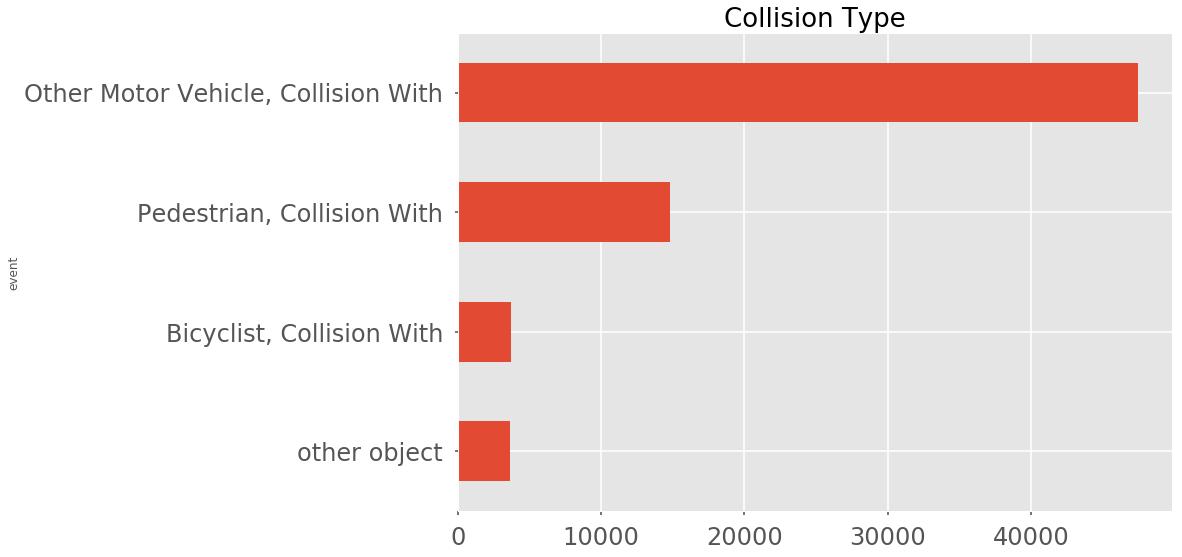

In [22]:
linked.fillna('other object').groupby(['event']).count()[['CI_ID']]\
.sort_values('CI_ID').plot(kind='barh',legend=False,fontsize=24)

plt.title('Collision Type',fontsize=26)

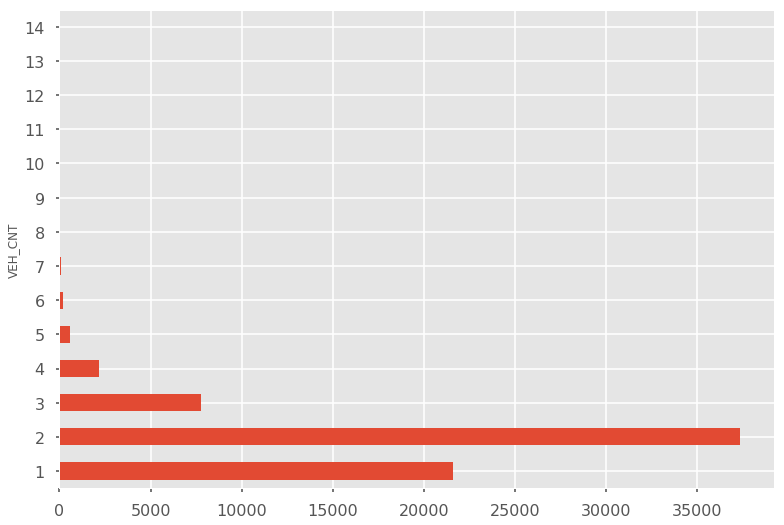

In [23]:
linked.groupby(linked.VEH_CNT.astype(int)).count()[['CI_ID']].plot(kind='barh',
                                                                   legend=False,
                                                                   )

In [24]:
linked[linked.CIROLET_ID.isin(['6','7'])].shape

(18092, 132)

In [25]:
ped.shape[0]/float(linked.shape[0])

0.2530111833699413

In [26]:
twoVeh.shape[0]/float(linked.shape[0])

0.5298390685788937

In [27]:
linked[~((linked.CI_ID.isin(ped.CI_ID))|(linked.CI_ID.isin(twoVeh.CI_ID)))]\
.groupby(['event']).count()[['CI_ID']]

,CI_ID
event,
"Bicyclist, Collision With",266
"Other Motor Vehicle, Collision With",10821
"Pedestrian, Collision With",660


In [28]:
linked.fillna('unknown')[~((linked.CI_ID.isin(ped.CI_ID))|(linked.CI_ID.isin(twoVeh.CI_ID)))]\
.groupby(['VEH_CNT']).count()[['CI_ID']]

,CI_ID
VEH_CNT,
1,3955
10,9
11,5
12,3
13,1
14,3
2,414
3,7754
4,2149


In [29]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby('VEHBDYT_ID_other').count()[['CI_ID']]

,CI_ID
VEHBDYT_ID_other,
1.0,3
2.0,2
3.0,5
4.0,49
5.0,334
6.0,437
7.0,25
10.0,10
15.0,12


bodytype 17 is unknown vehicle - I'm guessing these are hit and runs? or maybe the cop doesn't always record the vehicle and driver info?

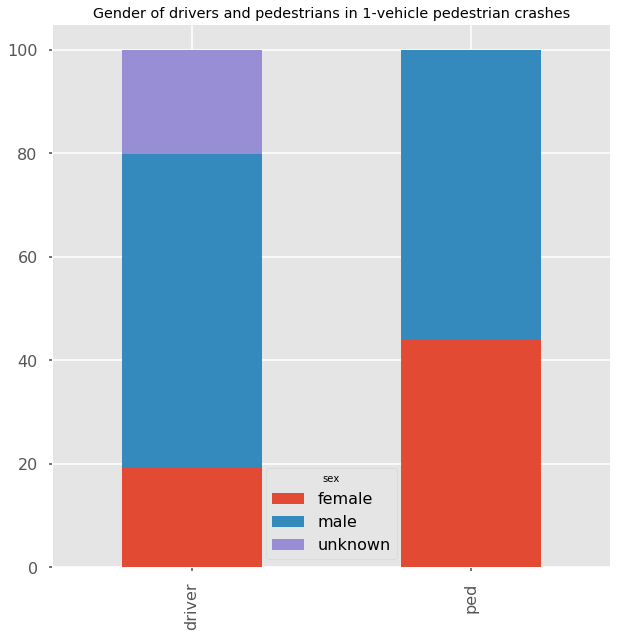

In [30]:
title = 'Gender of drivers and pedestrians in 1-vehicle pedestrian crashes'
pedSexCount = ped.groupby('f_per_sex').count()[['CI_ID']]/ped.shape[0]*100
pedSexCount.columns=['ped']
pedSexCount.index.name = 'sex'

driverSexCount = ped.groupby('f_driver_sex').count()[['CI_ID']]/ped.shape[0]*100
driverSexCount.columns = ['driver']
driverSexCount.index.name = 'sex'
driverSexCount.join(pedSexCount).T.plot(kind='bar',
                                        stacked=True,
                                        figsize=(10,10),title=title)

In [31]:
driverSexCount.join(pedSexCount)#.T.plot(kind='bar',stacked=True,figsize=(10,6))

,driver,ped
sex,,
female,19.428053,43.894689
male,60.485701,56.105311
unknown,20.086246,NaN


In [45]:
twoVeh.groupby('f_per_sex').count()[['CI_ID']]/twoVeh.shape[0]*100

,CI_ID
f_per_sex,
female,47.213266
male,52.786734


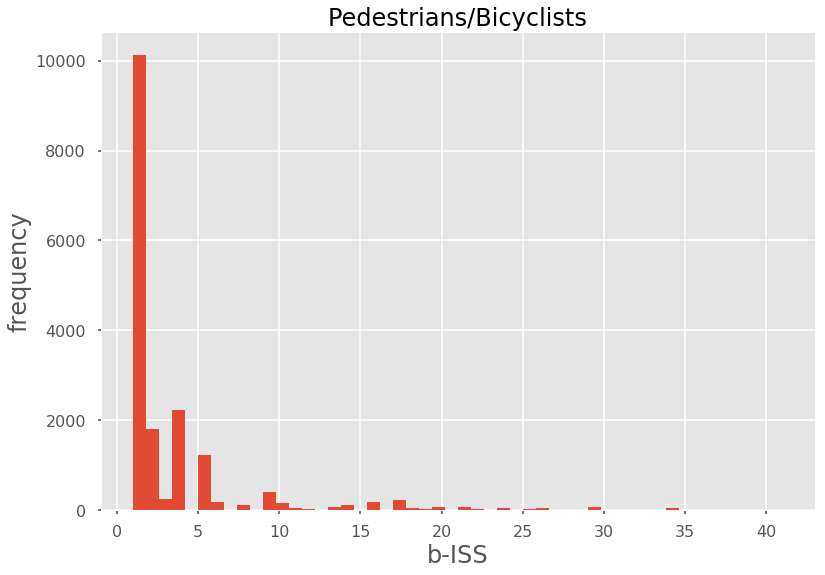

In [32]:
ped.hosp_biss.hist(bins=50)
plt.ylabel('frequency',fontsize=24)
plt.xlabel('b-ISS',fontsize=24)
plt.title('Pedestrians/Bicyclists',fontsize=24)

In [33]:
ped.shape

(17624, 103)

In [34]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,15916
True,1708


In [35]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,16725
True,899


In [36]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.903087
True,0.096913


In [37]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.94899
True,0.05101


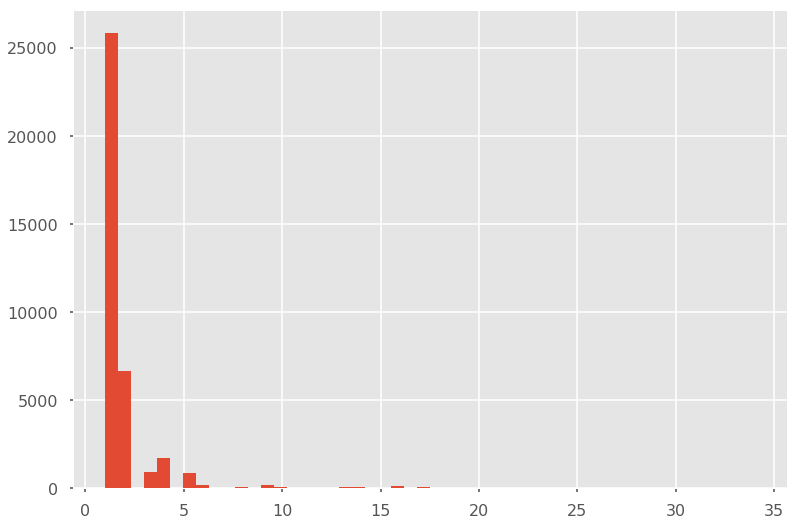

In [38]:
twoVeh.hosp_biss.hist(bins=50)

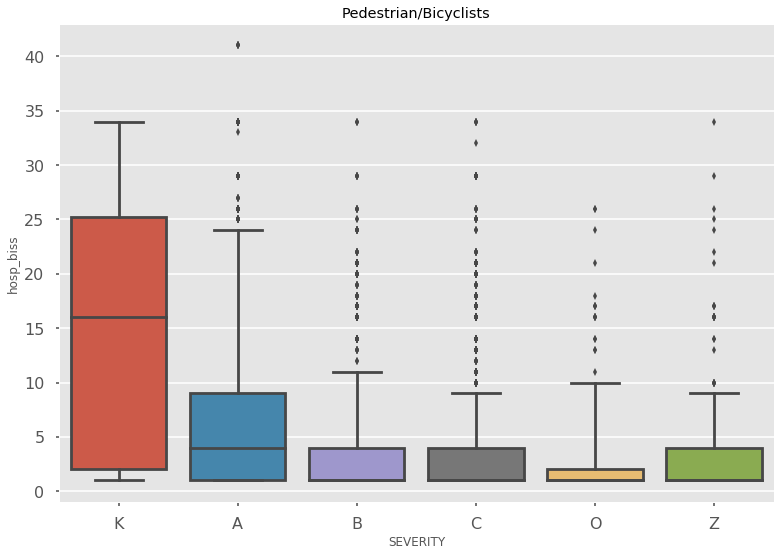

In [39]:
import seaborn as sns

sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'], whis=[5,95]
           ).set_title('Pedestrian/Bicyclists')

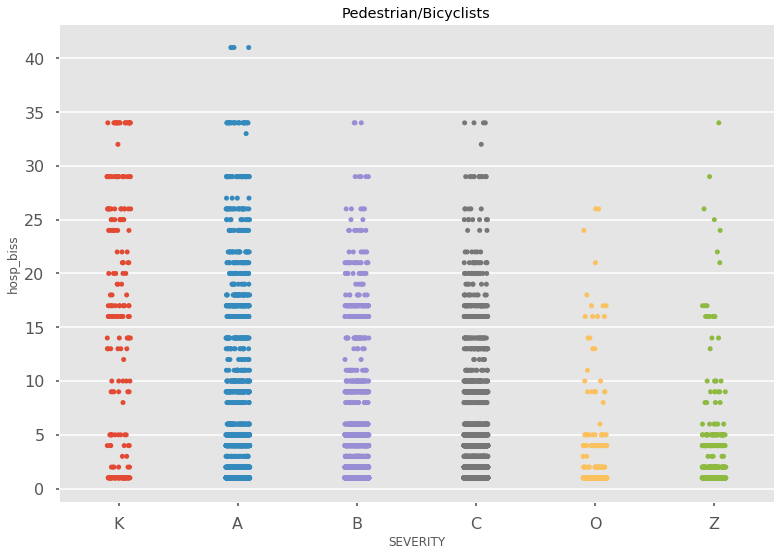

In [47]:
sns.stripplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'],jitter=True
           ).set_title('Pedestrian/Bicyclists')

In [48]:
ped.groupby('SEVERITY').count()[['CI_ID']]

,CI_ID
SEVERITY,
A,2205
B,3890
C,10452
K,220
O,326
Z,531


In [53]:
ped['kabco'] = ped[ped.SEVERITY.isin(['B','C','O'])].SEVERITY
ped.loc[ped.SEVERITY.isin(['K','A']),'kabco']='K/A'
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


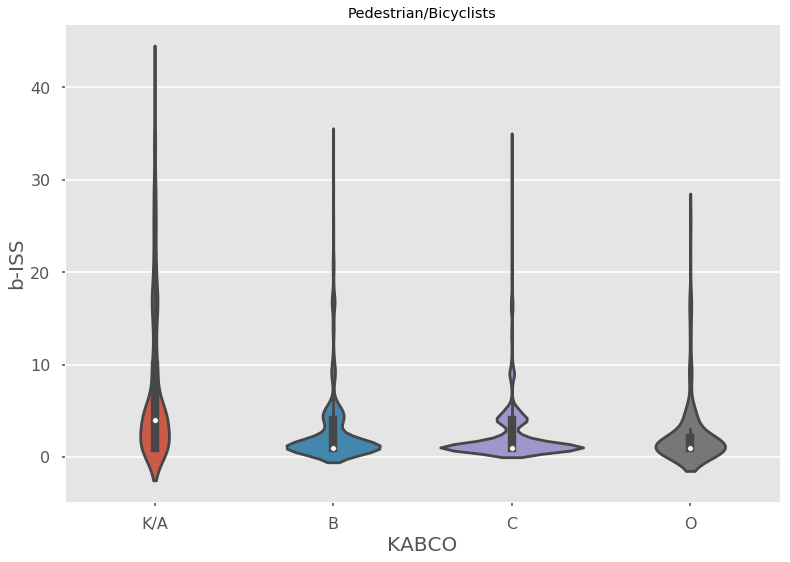

In [60]:
sns.violinplot(x='kabco',y='hosp_biss',
            data=ped,order=['K/A','B','C','O'], whis=[5,95],
           ).set_title('Pedestrian/Bicyclists')
plt.ylabel('b-ISS',fontsize=20)
plt.xlabel('KABCO',fontsize=20)

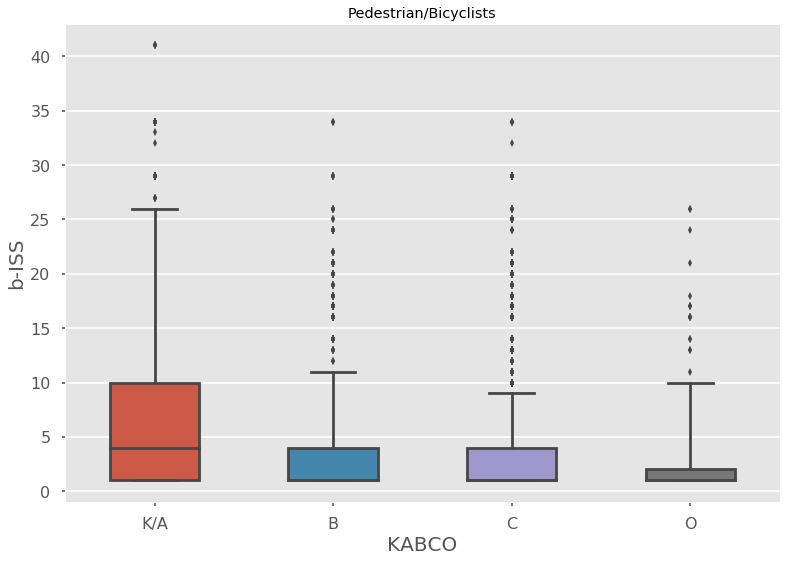

In [63]:
sns.boxplot(x='kabco',y='hosp_biss',
            data=ped,order=['K/A','B','C','O'], whis=[5,95],width=.5
           ).set_title('Pedestrian/Bicyclists')
plt.ylabel('b-ISS',fontsize=20)
plt.xlabel('KABCO',fontsize=20)

In [64]:
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


In [70]:
ct = pd.crosstab(ped.kabco=='K/A',ped.hosp_biss>8)
ct

hosp_biss,False,True
kabco,,
False,14240,959
True,1676,749


In [71]:
ped.shape[0]

17624

In [75]:
(14240+749)/float(ped.shape[0])

0.8504879709487063

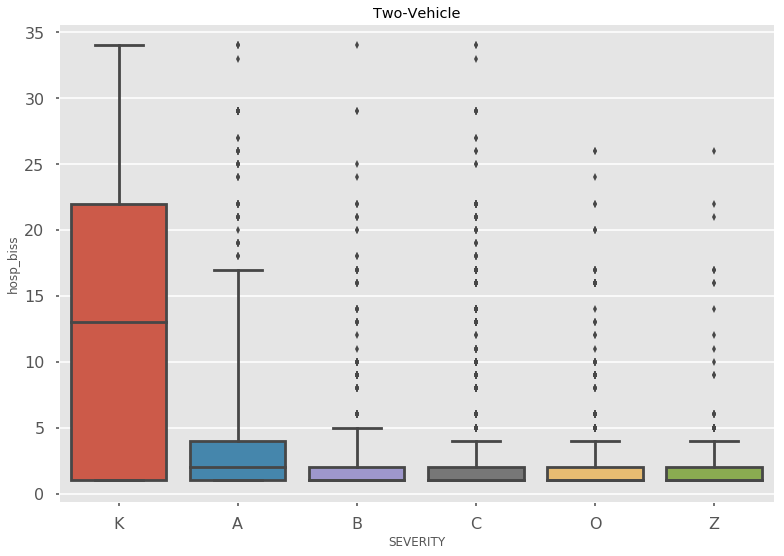

In [40]:
sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=twoVeh,order=['K','A','B','C','O','Z'], whis=[5,95],
           ).set_title('Two-Vehicle')